## Notes

Training on top of Resnet34 gave rubbish results, roughly the same as flipping a coin. Fine tuning Resnet34 gave decent results though, error rate of 10% on validation set. Training on top of Resnet50 gave crazy good results, no errors on the validation set (I mean, the validation set is really small, so say <5% error?).

My guess is that Resnet34 doesn't have features that can effectively distinguish between soccer and footy. However, a little bit of fine tuning is sufficient to build those features. Resnet50 on the other hand already has features that can distinguish between the two.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

In [4]:
images_path = 'soccer_vs_footy_images'
image_filenames = get_image_files(images_path)
image_filenames[:4]

[PosixPath('soccer_vs_footy_images/soccer_45.jpg'),
 PosixPath('soccer_vs_footy_images/footy_25.JPG'),
 PosixPath('soccer_vs_footy_images/soccer_20.jpg'),
 PosixPath('soccer_vs_footy_images/footy_33.jpg')]

In [5]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.(jpg|jpeg|JPG|JPEG|png)$'

In [7]:
data = ImageDataBunch.from_name_re(
    images_path, image_filenames, pat, ds_tfms=get_transforms(), size=224, bs=bs
).normalize()

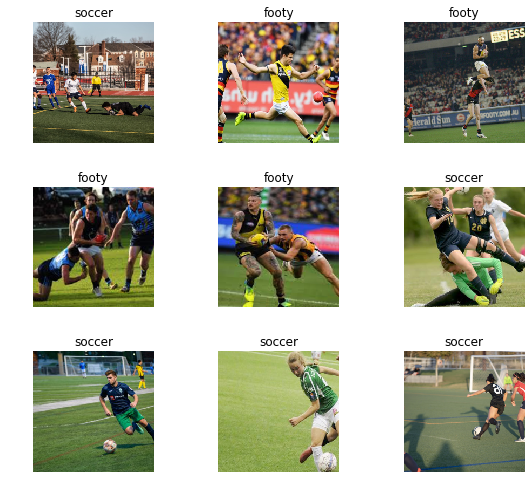

In [9]:
data.show_batch(rows=3, figsize=(8,7))

In [10]:
print(data.classes)

['footy', 'soccer']


In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 15124310.42it/s]


In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.858138,1.448311,0.578947,00:06
1,0.851048,1.187647,0.526316,00:05
2,0.715624,0.995920,0.421053,00:04
3,0.620368,0.851643,0.421053,00:04


In [13]:
learn.save('stage-1')

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

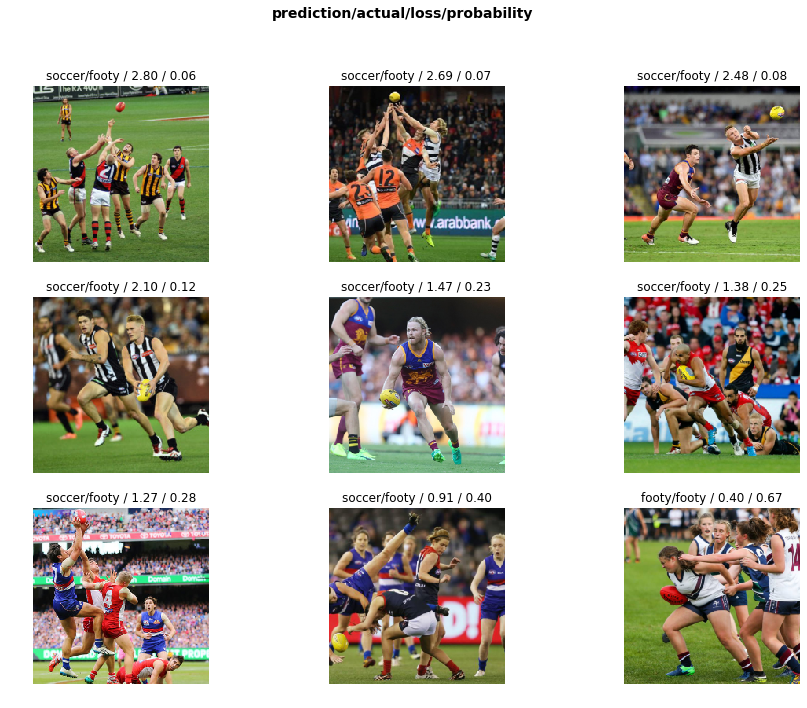

In [16]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

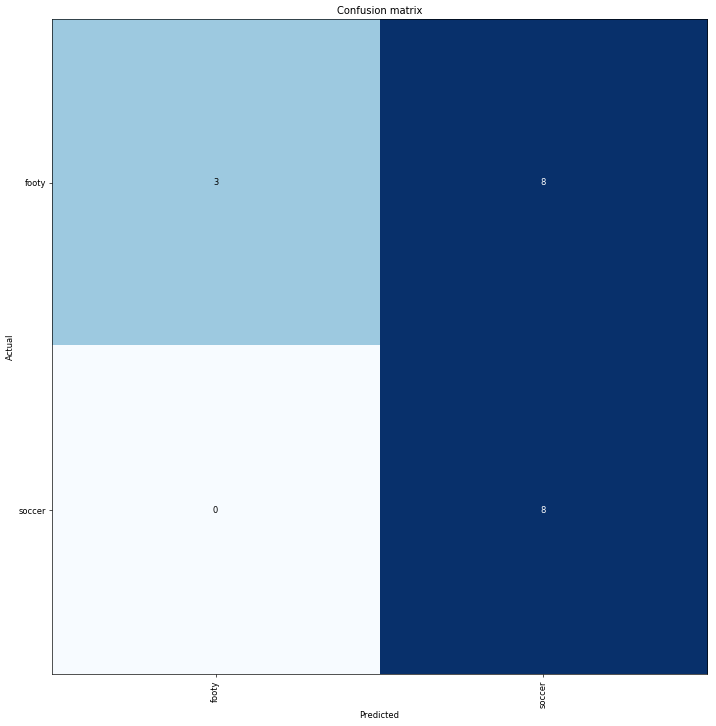

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Customising

In [29]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (80 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
footy,footy,footy,footy,soccer
Path: soccer_vs_footy_images;

Valid: LabelList (19 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
footy,footy,soccer,soccer,footy
Path: soccer_vs_footy_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [24]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


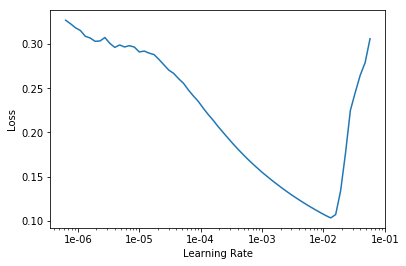

In [21]:
learn.recorder.plot()

In [30]:
# Validation loss is still going down in the fourth epoch.
# Accuracy isn't going up, but that might be just because the validation set is tiny.
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.379423,0.748908,0.368421,00:05
1,0.288875,0.487841,0.210526,00:05
2,0.215869,0.302548,0.105263,00:05
3,0.179390,0.207121,0.105263,00:05


In [26]:
interp_fine_tuned = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

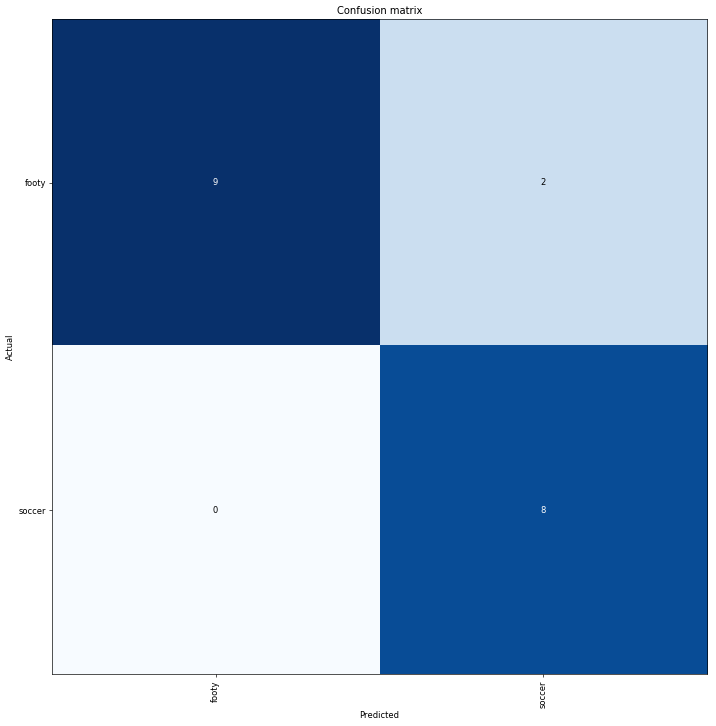

In [28]:
interp_fine_tuned.plot_confusion_matrix(figsize=(12,12), dpi=60)

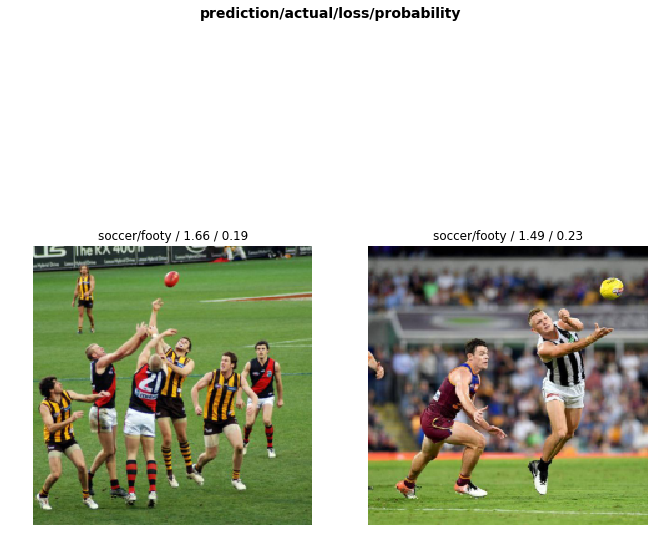

In [32]:
interp_fine_tuned.plot_top_losses(2, figsize=(11,11), heatmap=False)

## Resnet 50

In [33]:
data = ImageDataBunch.from_name_re(
    images_path, image_filenames, pat, ds_tfms=get_transforms(), size=299, bs=bs//2
).normalize()

In [34]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 18312916.59it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


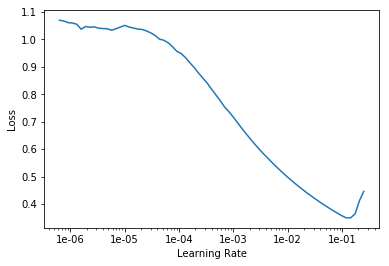

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.013086,0.756534,0.631579,00:07
1,0.770900,0.196835,0.052632,00:04
2,0.535141,0.091690,0.052632,00:04
3,0.398681,0.100371,0.052632,00:04
4,0.316281,0.108768,0.052632,00:04
5,0.265689,0.093801,0.000000,00:04
6,0.230674,0.074434,0.000000,00:04
7,0.205192,0.072480,0.000000,00:04
